<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/build-text-to-image-generator-from-scratch/02_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 4: Add captions to images





This is for the book Build a Text to Image Generator from Scratch by Mark Liu, published by Manning Publications. See https://mng.bz/vZem and https://github.com/markhliu for details.

Be sure to set the runtime type of this colab notebook to GPU. Click on the "Runtime" menu and select "Change runtime tpye" from the drop-down list. Then select "Python 3" as the runtime type and "T4 GPU" as the hardware accelerator.

In [1]:
# Run this cell first to make sure everything is set up correctly
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.9.0+cu126
True
Tesla T4


In [2]:
# clone the book's GitHub repository
!git clone https://github.com/markhliu/txt2img

Cloning into 'txt2img'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 436 (delta 83), reused 10 (delta 10), pack-reused 281 (from 2)
Receiving objects: 100% (436/436), 117.75 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [3]:
# allow access to local modules and files in the book's repository
import sys
sys.path.append("/content/txt2img")

## Download caption datasets

In [5]:
'''
download caption_datasets.zip from Andrej Karpathy's website
  (http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip).
  upload it to the folder /content/txt2img/files/ in this colab notebook
  Unzip the file as follows (make sure you have the file dataset_flickr8k.json):
  '''
!wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
!cp caption_datasets.zip /content/txt2img/files/
!unzip /content/txt2img/files/caption_datasets -d /content/txt2img/files/


--2026-01-19 05:57:59--  http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip [following]
--2026-01-19 05:57:59--  https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36745453 (35M) [application/zip]
Saving to: ‘caption_datasets.zip’

caption_datasets.zi 100%[===================>]  35.04M  74.4MB/s    in 0.5s    

2026-01-19 05:57:59 (74.4 MB/s) - ‘caption_datasets.zip’ saved [36745453/36745453]

Archive:  /content/txt2img/files/caption_datasets.zip
  inflating: /content/txt2img/files/dataset_coco.json  
  inflating: /content/txt

In [ ]:
'''
download the Flickr 8k images and the associated captions from the Kaggle website
(https://www.kaggle.com/datasets/adityajn105/flickr8k). Log in to your Kaggle account,
 download the zip file archive.zip, and upload it
  to the folder /content/txt2img/files/ in this colab notebook.
  Then unzip as follows'''
# !unzip /content/txt2img/files/archive -d /content/txt2img/files/

Let's read JSON file, which contains information
about the captions and corresponding tokens for each caption.

In [6]:
import json

with open('/content/txt2img/files/dataset_flickr8k.json', 'r') as fb:
    data = json.load(fb)

In [13]:
# Splitting data into train and test subsets
from collections import Counter

train_image_paths = []
train_image_captions = []
test_image_paths = []
test_image_captions = []
word_freq = Counter()

max_len=50
for img in data['images']:
    captions = []
    for c in img['sentences']:
        word_freq.update(c['tokens'])  # Gather information about text tokens to create a vocabulary
        if len(c['tokens']) <= max_len:
            captions.append(c['tokens'])  # Gather all captions
    if len(captions) == 0:
        continue
    path ="/content/txt2img/files/Images/"+img['filename']
    if img['split'] in {'train', 'val', 'restval'}:  # Create a train subset
        train_image_paths.append(path)
        train_image_captions.append(captions)
    elif img['split'] in {'test'}:  # Create a test subset
        test_image_paths.append(path)
        test_image_captions.append(captions)

In [14]:
assert len(train_image_paths)==len(train_image_captions)
assert len(test_image_paths)==len(test_image_captions)
print(f"there are {len(train_image_paths)} training images")
print(f"there are {len(test_image_paths)} test images")

there are 7000 training images
there are 1000 test images


## Building vocabulary

In [ ]:
min_word_freq=0
words = [w for w in word_freq.keys() if word_freq[w]>min_word_freq]
word2idx = {k:v + 4 for v,k in enumerate(words)}  #A
word2idx['<pad>'] = 0  #B
word2idx['<start>'] = 1  #B
word2idx['<end>'] = 2  #B
word2idx['<unk>'] = 3  #B
#A Create a dictionary to map tokens to indexes
#B Hard code in the special tokens


In [ ]:
indexes=[word2idx.get(token,3) for
         token in test_image_captions[0][0]]
print(indexes)


[12, 18, 318, 11, 12, 13, 11, 45, 30, 4, 234]


In [ ]:
idx2word={v:k for k, v in word2idx.items()}  #A
tokens=[idx2word.get(idx,"<unk>") for
         idx in indexes]  #B
print(tokens)
print(f"there are {len(idx2word)} unique tokens")
#A Create a dictionary idx2word to map indexes to tokens
#B Convert the sequence of indexes to tokens using the dictionary


['the', 'dogs', 'are', 'in', 'the', 'snow', 'in', 'front', 'of', 'a', 'fence']
there are 8387 unique tokens


In [ ]:
from utils.caption_util import FlickrD  #A

trainset=FlickrD(train_image_paths,
  train_image_captions,word2idx)  #B
testset=FlickrD(test_image_paths,
  test_image_captions,word2idx)  #C
#A Import the FlickrD() class from the local module
#B Generate the train subset using the FlickrD() class
#C Generate the test subset using the FlickrD() class


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True)  #A
test_loader = DataLoader(testset,
                        batch_size=128,
                        shuffle=True)  #B
#A Use the PyTorch DataLoader() class to generate a data iterator in the train subset
#B Generate a data iterator in the test subset


In [ ]:
test_images,test_tokens,\
    test_targets,test_mask=next(iter(test_loader))
import torch
torch.save((test_images,test_tokens),"/content/txt2img/files/tests.pt")


In [ ]:
def extract_patches(image_tensor, patch_size=8):
    bs, c, h, w = image_tensor.size()  #A
    unfold = torch.nn.Unfold(kernel_size=patch_size,
                             stride=patch_size)  #B
    unfolded = unfold(image_tensor)  #C
    unfolded = unfolded.transpose(1, 2).reshape(bs,
                    -1, c * patch_size * patch_size)  #D
    return unfolded
#A Obtain the dimensions of the image tensor
#B Define the unfold layer
#C Apply the unfold layer on the image tensor
#D Reshape the unfolded tensor to the desired shape


In [ ]:
from utils.caption_util import extract_patches

image=test_images[0].unsqueeze(0)  #A
patches=extract_patches(image,patch_size=8)  #B
print(patches.shape)  #C
#A Select an image from the test subset
#B Apply the extract_patches() function on the image
#C Print out the dimensions of the output


torch.Size([1, 256, 192])


In [ ]:
from torch import nn
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking
        self.multihead_attn=nn.MultiheadAttention(hidden_size,
             num_heads=num_heads,
             batch_first=True,
             dropout=0.0)  #A
    def forward(self, x_in, kv_in, key_mask=None):
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l,
                     device=x_in.device), 1).bool()  #B
        else:
            mask = None  #C
        return self.multihead_attn(x_in, kv_in, kv_in,
             attn_mask=mask,key_padding_mask=key_mask)[0]
#A Use the off-the-shelf MultiheadAttention() class in PyTorch
#B Create a mask if calculating masked multi-head attention
#C Do not apply mask otherwise


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4,
                 decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder
        self.norm1 = nn.LayerNorm(hidden_size)
        self.attn1 = AttentionBlock(hidden_size=hidden_size,
                                    num_heads=num_heads,
                                    masking=masking)
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            self.attn2 = AttentionBlock(hidden_size=hidden_size,
                            num_heads=num_heads, masking=False)
        self.norm_mlp = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
    def forward(self, x, input_key_mask=None,
                cross_key_mask=None, kv_cross=None):
        x = self.attn1(x, x, key_mask=input_key_mask) + x  #A
        x = self.norm1(x)
        if self.decoder:  #B
            x = self.attn2(x, kv_cross,key_mask=cross_key_mask) + x
            x = self.norm2(x)
        x = self.mlp(x) + x  #C
        return self.norm_mlp(x)
#A Calculate self attention
#B If it’s a decoder layer, calculate cross-attention
#C The output goes through the feed-forward network


In [ ]:
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in,
                 patch_size=16, hidden_size=128,
                 num_layers=6, num_heads=4):
        super(VisionEncoder, self).__init__()
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in*patch_size*patch_size,
                               hidden_size)
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding=nn.Parameter(torch.empty(1,seq_length,
                              hidden_size).normal_(std=0.02))
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
        decoder=False, masking=False) for _ in range(num_layers)
        ])  #A
    def forward(self, image):
        bs = image.shape[0]
        patch_seq = extract_patches(image,
              patch_size=self.patch_size)  #B
        patch_emb = self.fc_in(patch_seq)
        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding  #C
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)  #D
        return embs
#A The encoder consists of multiple encoder blocks
#B First convert images into sequences of patches
#C Add positional encodings to image embeddings
#D The input embeddings go through multiple encoder blocks


In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128,
                 num_layers=6, num_heads=4):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.embedding.weight.data=0.001*self.embedding.weight.data
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
                             decoder=True) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(hidden_size, num_emb)
    def forward(self, input_seq, encoder_output,
                input_padding_mask=None,
                encoder_padding_mask=None):
        input_embs = self.embedding(input_seq)  #A
        bs, l, h = input_embs.shape
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1,
                             l, h).expand(bs, l, h)
        embs = input_embs + pos_emb  #B
        for block in self.blocks:
            embs = block(embs,
                           input_key_mask=input_padding_mask,
                           cross_key_mask=encoder_padding_mask,
                           kv_cross=encoder_output)  #C
        return self.fc_out(embs)  #D
#A Pass the input sequence through the embedding layer
#B Add positional encoding to the word embedding
#C The input embedding goes through multiple decoder layers
#D The output from the decoder layers goes through a linear layer, with the number of outputs equal to the English vocabulary


In [ ]:
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in,
                 num_emb, patch_size=16,
                 hidden_size=128, num_layers=(6,6),
                 num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        self.encoder = VisionEncoder(
            image_size=image_size, channels_in=channels_in,
            patch_size=patch_size, hidden_size=hidden_size,
            num_layers=num_layers[0], num_heads=num_heads)
        self.decoder = Decoder(num_emb=num_emb,
            hidden_size=hidden_size,
            num_layers=num_layers[1], num_heads=num_heads)
    def forward(self, input_image, target_seq, padding_mask):
        bool_padding_mask = padding_mask == 0  #A
        encoded_seq = self.encoder(image=input_image)  #B
        decoded_seq = self.decoder(input_seq=target_seq,
                         encoder_output=encoded_seq,
                    input_padding_mask=bool_padding_mask)  #C
        return decoded_seq
#A Generate padding masks for the text in the captions to ensure all sequences in the same batch have the same length
#B Encode the images and pass image embeddings to the decoder
#C Predict the output sequence


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_size = 192  #A
num_layers = (6, 6)  #B
num_heads = 8  #C
patch_size = 8  #D
#A Each image token is represented by a 192-value vector
#B Number of transformer blocks for the encoder and decoder, respectively
#C Number of attention head in multi-head attention
#D Each image patch is 8 pixels wide and 8 pixels tall


In [ ]:
from utils.caption_util import VisionEncoderDecoder

caption_model = VisionEncoderDecoder(
    image_size=128, channels_in=3,
    num_emb=len(word2idx), patch_size=patch_size,
    num_layers=num_layers,hidden_size=hidden_size,
    num_heads=num_heads).to(device)


In [ ]:
optimizer = torch.optim.Adam(caption_model.parameters(),
                             lr=0.0001)
scaler = torch.amp.GradScaler("cuda")
loss_fn = nn.CrossEntropyLoss(reduction="none")


In [ ]:
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]
print(f"This model has {num_model_params} parameters")


This model has 9545219 parameters


In [ ]:
from tqdm import tqdm

for epoch in range(0, 50):  #A
    caption_model.train()
    eloss=0
    for images,inputs,outputs,masks in tqdm(train_loader):
        images = images.to(device)
        tokens_in = inputs.to(device)
        padding_mask = masks.to(device)
        target_ids = outputs.to(device)
        with torch.amp.autocast("cuda"):
            pred = caption_model(images, tokens_in,  #B
                                 padding_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2),  #C
                            target_ids) * padding_mask).mean()
        optimizer.zero_grad()
        scaler.scale(loss).backward()  #D
        scaler.step(optimizer)
        scaler.update()
        eloss+=loss.item()
    print(f"epoch {epoch}, loss is {eloss/len(train_loader)}")
torch.save(caption_model.state_dict(),"/content/txt2img/files/caption.pth")
#A Train the model for 50 epochs
#B Pass the image and input sequence of the caption through the model to generate predictions
#C Calculates the loss by comparing the predictions with the actual output sequence
#D Backpropagation: modify model parameters to minimize the cross-entropy loss


In [ ]:
def caption(image,temp=1.0):
    sos_token = 1 * torch.ones(1, 1).long()  #A
    log_tokens = [sos_token]
    caption_model.eval()
    with torch.no_grad():
        image_embedding = caption_model.encoder(
             image.to(device))  #B
        for i in range(50):  #C
            input_tokens = torch.cat(log_tokens, 1)
            data_pred = caption_model.decoder(
                input_tokens.to(device),image_embedding)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            next_tokens = dist.sample().reshape(1, 1)
            log_tokens.append(next_tokens.cpu())
            if next_tokens.item() == 2:  #D
                break
    pred_text = torch.cat(log_tokens, 1)
    pred_text_strings = [idx2word.get(i,"<unk>") for
                 i in pred_text[0].tolist() if i>3]
    pred_text = " ".join(pred_text_strings)
    return pred_text
#A Add the start-of-sentence token <start> to the prompt
#B Use the trained model to encode the image
#C Generate a caption one token at a time
#D Stop generating when the next token is the end-of-sentence token <end>


In [ ]:
def compare(images, captions, index, temp=1.0):
    image = images[index].unsqueeze(0)  #A
    capi=captions[index]  #B
    capt=[idx2word.get(i,"UNK") for i in capi.tolist() if i>3]
    cap=" ".join(capt)
    pred=caption(image,temp=temp)  #C
    out=torchvision.utils.make_grid(image, 1, normalize=True)
    plt.figure(figsize=(5,10),dpi=100)
    out = torchvision.utils.make_grid(image, 1, normalize=True)
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.title(  #D
    f"**Original caption:\n"+cap+"\n**Generated caption:\n"+pred,
              wrap=True, loc="left", fontsize=18)
    plt.axis("off")
    plt.show()
#A Retrieve the image from the test set
#B Retrieve the caption from the test set
#C Generate a caption using the trained model
#D Plot the image with both the generated caption and the original caption


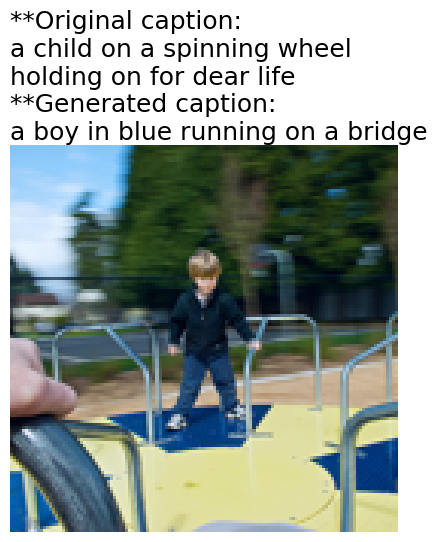

In [ ]:
from torch.distributions import Categorical
import torchvision
import matplotlib.pyplot as plt

caption_model.load_state_dict(torch.load("/content/txt2img/files/caption.pth",
    weights_only=True,
    map_location=device))
compare(test_images, test_tokens, 0, temp=0.75)
